In [8]:
%matplotlib inline
import torch
import pandas as pd
import matplotlib.pyplot as plt
import torch.optim as optim
torch.set_printoptions(edgeitems=2, linewidth=75)

In [9]:
# CSVファイルの読み込み
df1 = pd.read_csv('xy(1).csv')
df2 = pd.read_csv('xy(2).csv')
df3 = pd.read_csv('xy(3).csv')
df4 = pd.read_csv('xy1.csv')
df5 = pd.read_csv('xy2.csv')
df6 = pd.read_csv('xy3.csv')

# データの抽出
x1 = df1['x'].values
y1 = df1['y'].values
x2 = df2['x'].values
y2 = df2['y'].values
x3 = df3['x'].values
y3 = df3['y'].values
x4 = df4['x'].values
y4 = df4['y'].values
x5 = df5['x'].values
y5 = df5['y'].values
x6 = df6['x'].values
y6 = df6['y'].values

x1 = torch.tensor(x1, dtype=torch.float32, requires_grad=True)
y1 = torch.tensor(y1, dtype=torch.float32)
x2 = torch.tensor(x2, dtype=torch.float32, requires_grad=True)
y2 = torch.tensor(y2, dtype=torch.float32)
x3 = torch.tensor(x3, dtype=torch.float32, requires_grad=True)
y3 = torch.tensor(y3, dtype=torch.float32)
x4 = torch.tensor(x4, dtype=torch.float32, requires_grad=True)
y4 = torch.tensor(y4, dtype=torch.float32)
x5 = torch.tensor(x5, dtype=torch.float32, requires_grad=True)
y5 = torch.tensor(y5, dtype=torch.float32)
x6 = torch.tensor(x6, dtype=torch.float32, requires_grad=True)
y6 = torch.tensor(y6, dtype=torch.float32)

In [10]:
def rotation_matrix(n, theta):
    """
    Compute the Rodrigues rotation matrix for a given axis n and angle theta.

    Parameters:
        n (torch.Tensor): Rotation axis (normalized).
        theta (float): Rotation angle in radian.

    Returns:
        - (torch.Tensor) -- 3x3 rotation matrix.
    """
    K = torch.tensor([[0.0, -n[2], n[1]], 
                      [n[2], 0.0, -n[0]], 
                      [-n[1], n[0], 0.0]])
    I = torch.eye(3)
    R = I + torch.sin(theta) * K + (1.0 - torch.cos(theta)) * torch.mm(K, K)
    return R

def cross_product(v1, v2):
    return torch.cross(v1, v2, dim=0)

def magnetic(axis, vec, theta):
    cos_theta = torch.cos(theta)
    sin_theta = torch.sin(theta)
    
    axis = axis.unsqueeze(0)  # (1, 3)
    vec = vec.unsqueeze(0)    # (1, 3)
    
    rotated_vecs = []
    for i in range(theta.size(0)):
        theta_i = theta[i]
        cos_theta_i = cos_theta[i]
        sin_theta_i = sin_theta[i]
        
        axis_i = axis[0]
        vec_i = vec[0]
        
        rotated_vec = vec_i * cos_theta_i + cross_product(axis_i, vec_i) * sin_theta_i + axis_i * (torch.matmul(axis_i.unsqueeze(1).T, vec_i.unsqueeze(1)).squeeze() * (1 - cos_theta_i))
        rotated_vecs.append(rotated_vec)
    
    return torch.stack(rotated_vecs)

def model(x, k1, k2, k3, k4, k5, k6, t1, p1, t2, p2):
    rad = torch.pi / 180.0  # Conversion factor from degrees to radians
    nx = torch.cos(p1 * rad) * torch.sin(t1 * rad)
    ny = torch.sin(p1 * rad) * torch.sin(t1 * rad)
    nz = torch.cos(t1 * rad)
    sx = torch.cos(p2 * rad) * torch.sin(t2 * rad)
    sy = torch.sin(p2 * rad) * torch.sin(t2 * rad)
    sz = torch.cos(t2 * rad)
    theta = x * rad

    # Define matrices
    E = torch.eye(3)
    C3 = rotation_matrix(torch.tensor([0.0, 0.0, 1.0]), torch.tensor([2.0 * torch.pi / 3.0])) # for Te2.
    C3i = C3.T # for Te3.
    Rs = [E, C3i, C3]
    
    h = magnetic(torch.stack([nx, ny, nz]), torch.stack([sx, sy, sz]), theta)
    ht = magnetic(cross_product(torch.stack([nx, ny, nz]), torch.stack([sx, sy, sz])), torch.tensor([sx, sy, sz]), theta)
    k = torch.stack([
    torch.stack([k1, k6, k5]),
    torch.stack([k6, k2, k4]),
    torch.stack([k5, k4, k3])
    ])
    Ks = [torch.einsum('ik,kl,jl->ij', R, k, R) for R in Rs]
    shift1 = [torch.einsum('ij,jk,ik->i', h, K, h) for K in Ks]
    shift2 = [torch.einsum('ij,jk,ik->i', ht, K, ht) for K in Ks]
    
    return {'shift1': shift1, 'shift2': shift2}

In [11]:
def loss_fn(y_p, y):
    squared_diffs = (y_p - y)**2
    return squared_diffs.mean()

In [12]:
def combined_loss_fn(y_p1, y1, y_p2, y2, y_p3, y3, y_p4, y4, y_p5, y5, y_p6, y6):
    loss1 = loss_fn(y_p1, y1)
    loss2 = loss_fn(y_p2, y2)
    loss3 = loss_fn(y_p3, y3)
    loss4 = loss_fn(y_p4, y4)
    loss5 = loss_fn(y_p5, y5)
    loss6 = loss_fn(y_p6, y6)

    total_loss = loss1 + loss2 + loss3 + loss4 + loss5 + loss6
    return total_loss

In [13]:
# Define model parameters as torch.nn.Parameter
k1 = torch.nn.Parameter(torch.tensor(0.0))
k2 = torch.nn.Parameter(torch.tensor(0.0))
k3 = torch.nn.Parameter(torch.tensor(0.0))
k4 = torch.nn.Parameter(torch.tensor(0.0))
k5 = torch.nn.Parameter(torch.tensor(0.0))
k6 = torch.nn.Parameter(torch.tensor(0.0))
t1 = torch.nn.Parameter(torch.tensor(0.0))
p1 = torch.nn.Parameter(torch.tensor(0.0))
t2 = torch.nn.Parameter(torch.tensor(0.0))
p2 = torch.nn.Parameter(torch.tensor(0.0))

# Use an optimizer
optimizer = optim.Adam([k1, k2, k3, k4, k5, k6, t1, p1, t2, p2], lr=1e-2)

# Training loop
for epoch in range(100):  # Run for a sufficient number of epochs
    optimizer.zero_grad()  # Clear previous gradients

    # Forward pass
    outputs1 = model(x1, k1, k2, k3, k4, k5, k6, t1, p1, t2, p2)
    outputs2 = model(x2, k1, k2, k3, k4, k5, k6, t1, p1, t2, p2)
    outputs3 = model(x3, k1, k2, k3, k4, k5, k6, t1, p1, t2, p2)
    outputs4 = model(x4, k1, k2, k3, k4, k5, k6, t1, p1, t2, p2)
    outputs5 = model(x5, k1, k2, k3, k4, k5, k6, t1, p1, t2, p2)
    outputs6 = model(x6, k1, k2, k3, k4, k5, k6, t1, p1, t2, p2)
    
    y_p1 = outputs1['shift1'][0]
    y_p2 = outputs2['shift1'][1]
    y_p3 = outputs3['shift1'][2]
    y_p4 = outputs4['shift2'][0]
    y_p5 = outputs5['shift2'][1]
    y_p6 = outputs6['shift2'][2]
    
    loss = combined_loss_fn(y_p1, y1, y_p2, y2, y_p3, y3, y_p4, y4, y_p5, y5, y_p6, y6)
    
    # Backward pass
    loss.backward()
    
    # Update parameters
    optimizer.step()
    
    # Print loss for monitoring
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')

Epoch 0, Loss: 154.01950073242188
Epoch 10, Loss: 151.0374298095703
Epoch 20, Loss: 148.15267944335938
Epoch 30, Loss: 145.37496948242188
Epoch 40, Loss: 142.7095184326172
Epoch 50, Loss: 140.15798950195312
Epoch 60, Loss: 137.7195587158203
Epoch 70, Loss: 135.39219665527344
Epoch 80, Loss: 133.17323303222656
Epoch 90, Loss: 131.05967712402344


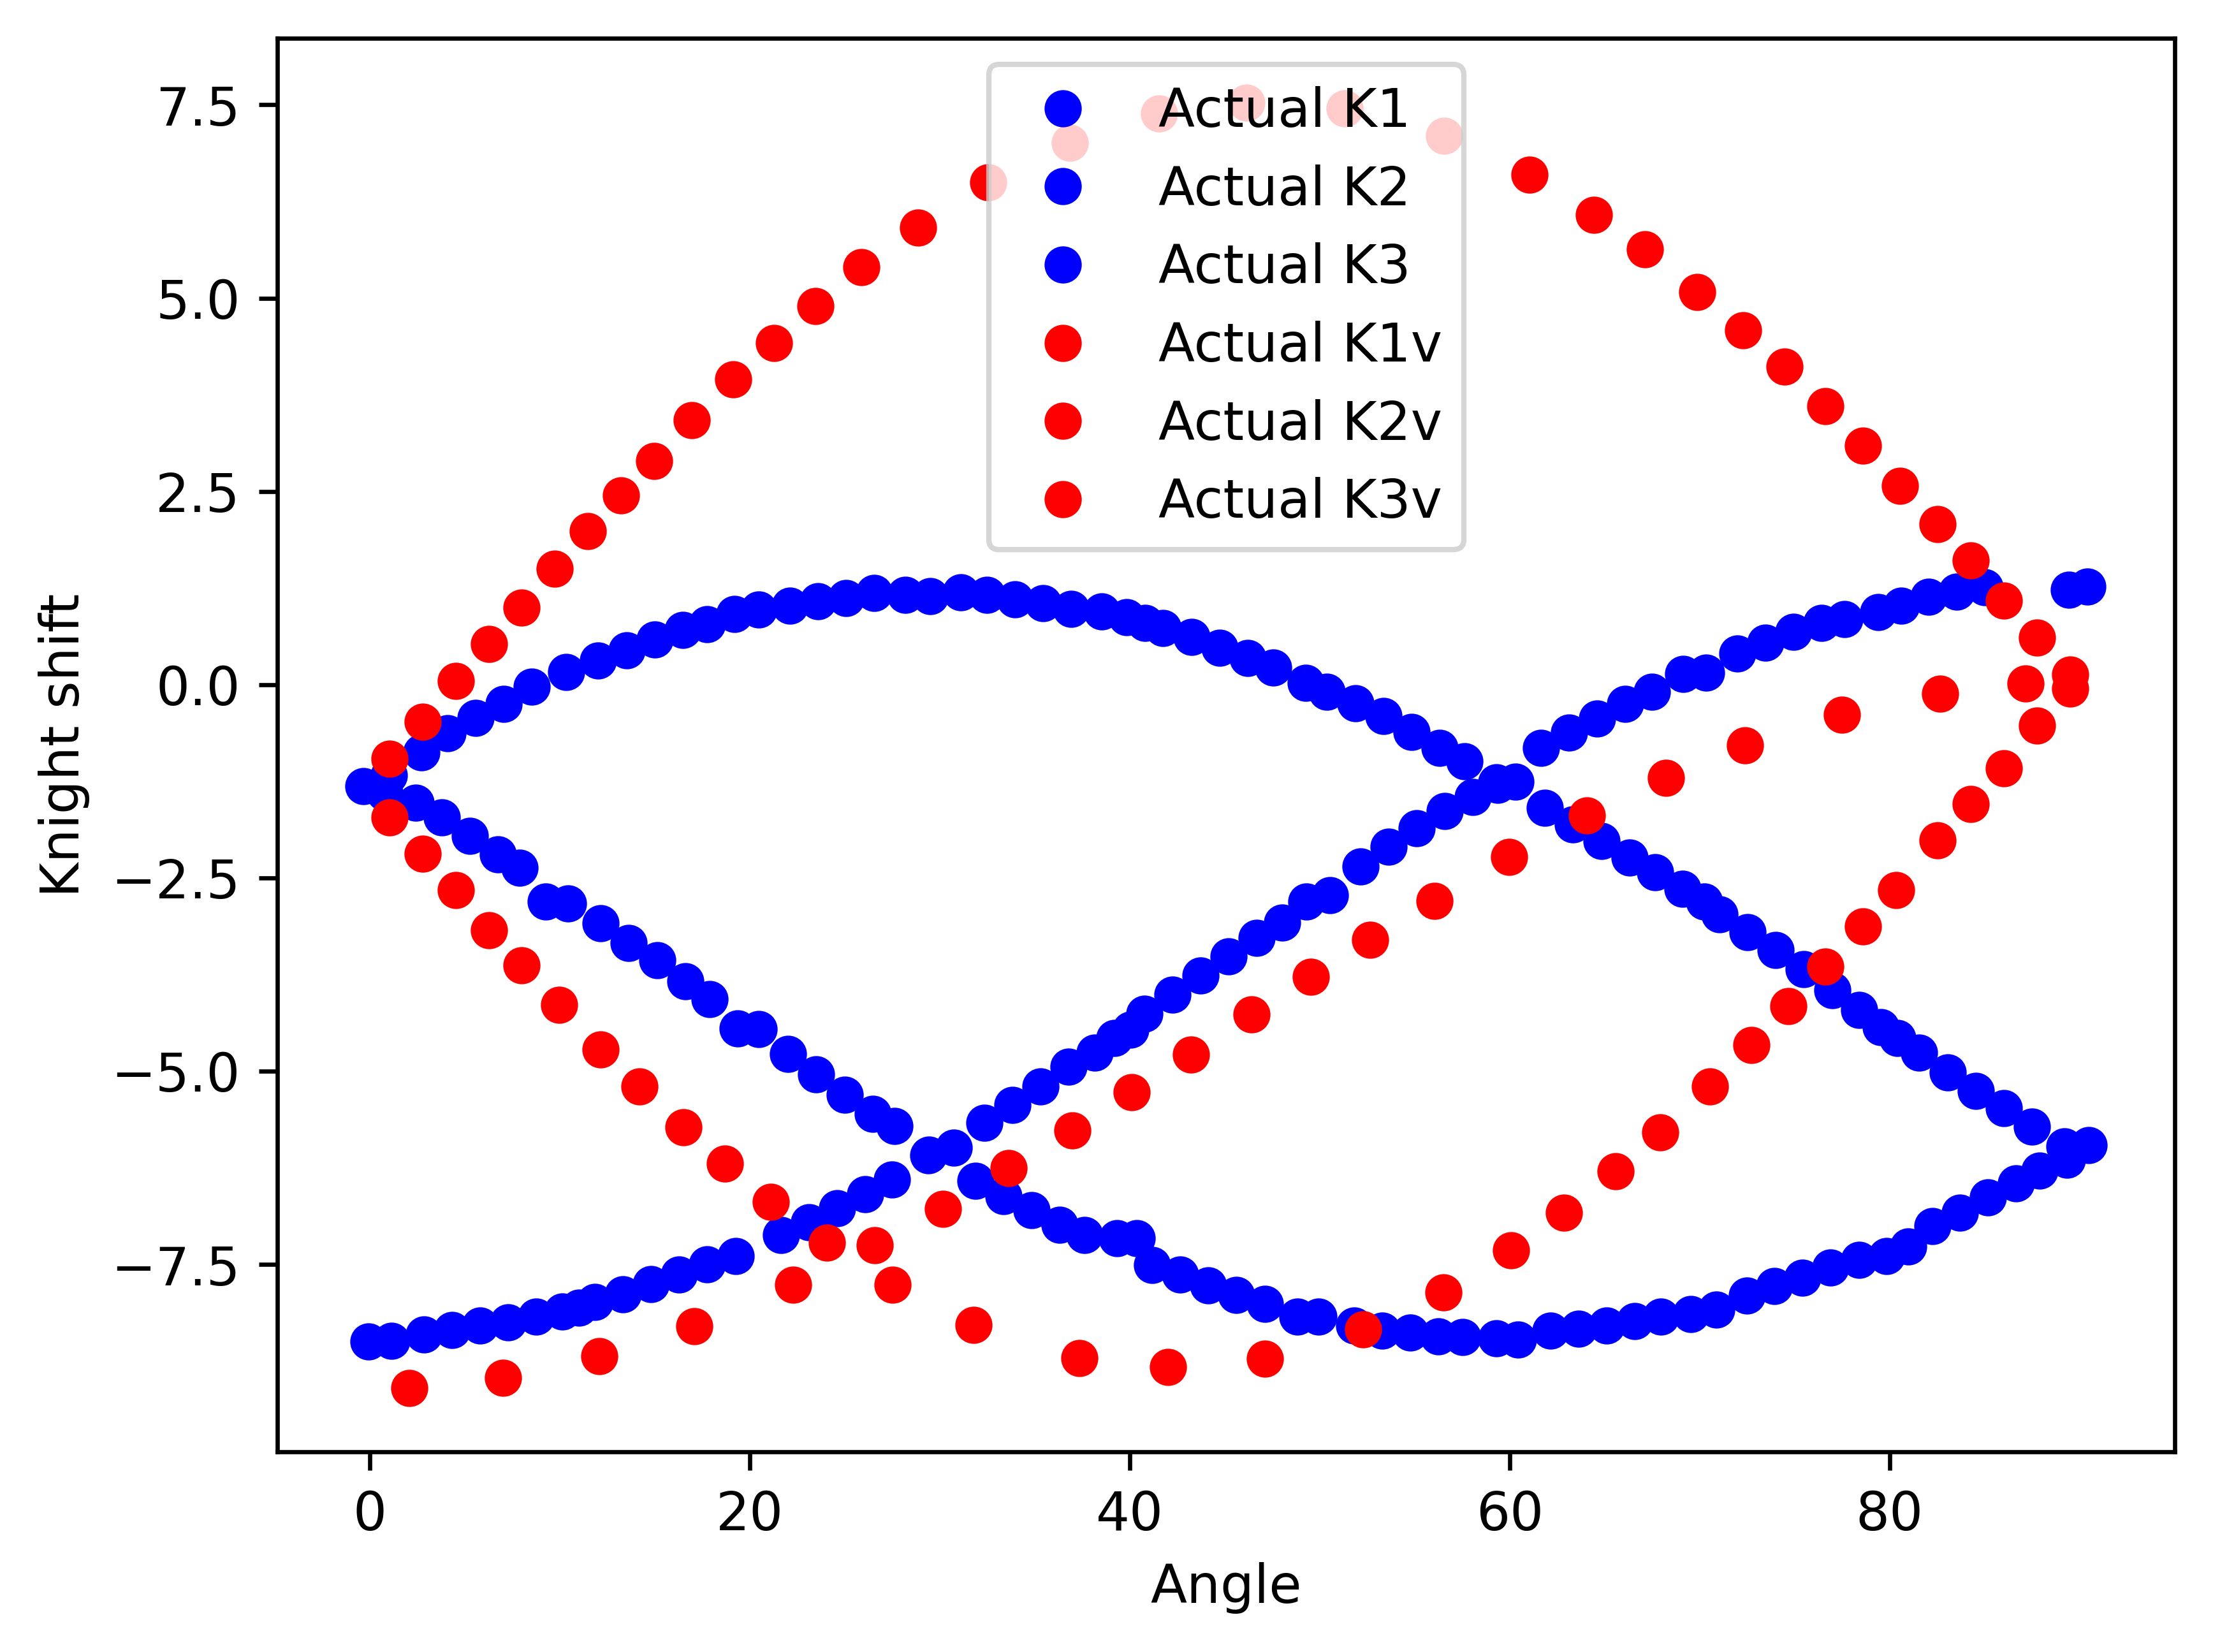

[tensor(0.), tensor(0.), tensor(-0.9493), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.)]


In [14]:
# 最適化後のパラメータを取得し、Tensorに変換
params = [torch.tensor(val) for val in [k1.item(), k2.item(), k3.item(), k4.item(), k5.item(), k6.item(), t1.item(), p1.item(), t2.item(), p2.item()]]

outputs1 = model(x1, k1, k2, k3, k4, k5, k6, t1, p1, t2, p2)
outputs2 = model(x2, k1, k2, k3, k4, k5, k6, t1, p1, t2, p2)
outputs3 = model(x3, k1, k2, k3, k4, k5, k6, t1, p1, t2, p2)
outputs4 = model(x4, k1, k2, k3, k4, k5, k6, t1, p1, t2, p2)
outputs5 = model(x5, k1, k2, k3, k4, k5, k6, t1, p1, t2, p2)
outputs6 = model(x6, k1, k2, k3, k4, k5, k6, t1, p1, t2, p2)

y_p1 = outputs1['shift1'][0]
y_p2 = outputs2['shift1'][1]
y_p3 = outputs3['shift1'][2]
y_p4 = outputs4['shift2'][0]
y_p5 = outputs5['shift2'][1]
y_p6 = outputs6['shift2'][2]

# 結果の可視化
fig = plt.figure(dpi=600)

plt.plot(x1.detach().numpy(), y_p1.detach().numpy(), label="Predicted K1", color = "blue") 
plt.plot(x1.detach().numpy(), y1.numpy(), 'o', label="Actual K1", color = "blue")

plt.plot(x2.detach().numpy(), y_p2.detach().numpy(), label="Predicted K2", color = "red") 
plt.plot(x2.detach().numpy(), y2.numpy(), 'o', label="Actual K2", color = "blue")

plt.plot(x3.detach().numpy(), y_p3.detach().numpy(), label="Predicted K3", color = "orange") 
plt.plot(x3.detach().numpy(), y3.numpy(), 'o', label="Actual K3", color = "blue")

plt.plot(x4.detach().numpy(), y_p4.detach().numpy(), label="Predicted K1v", color = "green") 
plt.plot(x4.detach().numpy(), y4.numpy(), 'o', label="Actual K1v", color = "red")

plt.plot(x5.detach().numpy(), y_p5.detach().numpy(), label="Predicted K2v", color = "purple") 
plt.plot(x5.detach().numpy(), y5.numpy(), 'o', label="Actual K2v", color = "red")

plt.plot(x6.detach().numpy(), y_p6.detach().numpy(), label="Predicted K3v", color = "black") 
plt.plot(x6.detach().numpy(), y6.numpy(), 'o', label="Actual K3v", color = "red")

plt.xlabel("Angle")
plt.ylabel("Knight shift")
plt.legend()
plt.show()
print(params)